In [8]:
import torch
vector1d = torch.load("/Users/mxm/Google Drive/Masterstudium/Inhalte/4th Semester/NLP/nlp-project/coding/code/exchange_base/val_vectorized_1d.pt")
vector2d = torch.load("/Users/mxm/Google Drive/Masterstudium/Inhalte/4th Semester/NLP/nlp-project/coding/code/exchange_base/val_vectorized_2d.pt")
print(vector1d.size())
print(vector2d.size())

torch.Size([16613, 120])
torch.Size([16613, 2, 120])


In [2]:
import pandas as pd

original_df = pd.DataFrame({"text":"★THE GATEWAY 2★ ✔https://t.co/SSmqhC8rBA https://t.co/8jSwD7zC61 @Spokenamos #bookboost #ASMSG #kindle https://t.co/OdoRyxfrtp", "label":2}, {"text":"Hey #Sweden how you liking those immigrants now? #Stockholm Wonder how many will say it's not radical islamic terro… https://t.co/7V9UWL3S5f", "label":2})


OUTLINE

MODULE 1: Data preprocessing and loading

(a) Obtaining and cleaning the datasets

(b) Twitter specific text pre-processing

(c) Word / sentence vectorisation (as first data input)

Michael: BERT and FastText

(d) Implementing a dictionary approach potentially based on Hatebase.org (as second data input)
(e) Splitting data into test, validation and testing set
(f) Specifying and implementing the data loader
(g) Testing and iterating the module
(h) Creatingmodule-specificvisualisationsforthefinal paper

MODULE 2: Model architecture and training

(a) Choosing width and depth of the model
(b) Choosingoptimizeraswellasactivationandloss functions
(c) Choosing stopping rule, regularisation, dropout, learning rates etc.
(d) Potentially performing a hyperparameter grid search
(e) Running and tracking the training
(f) Training and tuning the model based on the re- sults of the validation set
(g) Creatingmodule-specificvisualisationsforthefi- nal paper

In [23]:
import pandas as pd
import matplotlib
import seaborn as sns
import numpy as np

In [2]:
hatebase_url = "https://raw.githubusercontent.com/MaximilianKupi/nlp-project/master/coding/data/dictionary/hatebase/full_dictionary.csv"
hatebase_dic = pd.read_csv(hatebase_url, index_col = 'vocabulary_id')

In [8]:
hatebase_dic.average_offensiveness.mean()

77.27734806629834

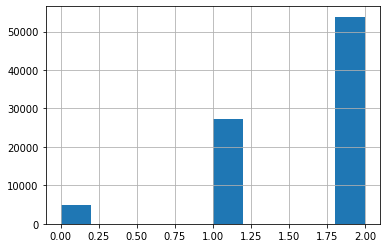

In [3]:
# (a) Obtaining and cleaning the datasets
url_davidson = "/Users/mxm/Google Drive/Masterstudium/Inhalte/4th Semester/NLP/nlp-project/coding/data/twitter data/davidson et al/labeled_data.csv"
url_founta = "/Users/mxm/Google Drive/Masterstudium/Inhalte/4th Semester/NLP/nlp-project/coding/data/twitter data/founta et al/hatespeech_text_label_vote.csv"


data_davidson = pd.read_csv(url_davidson, names=["count", "hate_speech", "offensive_language", "neither", "label", "tweet"], header=1)
data_founta = pd.read_csv(url_founta, sep='\t', names=["tweet", "label_text", "count"])

data_founta = data_founta[~data_founta.label_text.str.contains("spam")]
data_founta['label'] = data_founta.label_text.replace({'hateful': '0', 'abusive': '1', 'normal': '2'}).astype('int')
data_founta.label.hist()

# concatinating and shuffling


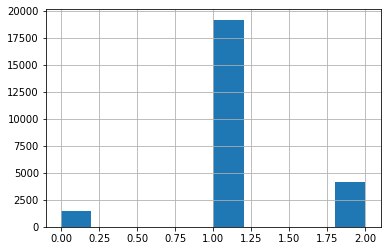

In [4]:
data_davidson.label.hist()

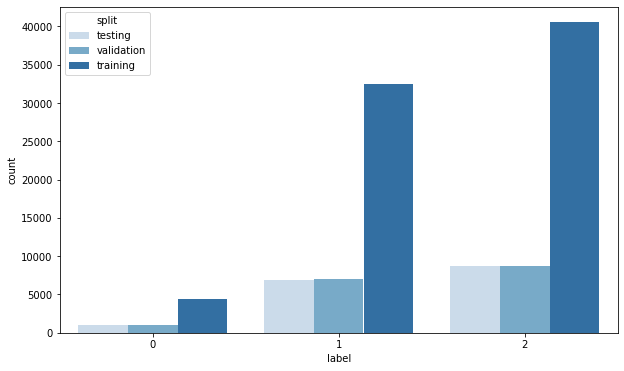

In [29]:
import pandas as pd
df_test = pd.read_csv("/Users/mxm/Google Drive/Masterstudium/Inhalte/4th Semester/NLP/nlp-project/coding/code/exchange_base/test_set.csv")
df_val = pd.read_csv("/Users/mxm/Google Drive/Masterstudium/Inhalte/4th Semester/NLP/nlp-project/coding/code/exchange_base/val_set.csv")
df_train = pd.read_csv("/Users/mxm/Google Drive/Masterstudium/Inhalte/4th Semester/NLP/nlp-project/coding/code/exchange_base/train_set.csv")
df_test['split'] = 'testing'
df_val['split'] ='validation'
df_train['split']='training'
df = pd.concat([df_test, df_val, df_train])
df
plt.figure(figsize=(10, 6))
sns.countplot(x="label", hue="split", data=df, palette='Blues', )
plt.show()

In [2]:
url_data_cleaned = 'https://raw.githubusercontent.com/MaximilianKupi/nlp-project/master/coding/code/exchange_base/data.csv'

data_cleaned = pd.read_csv(url_data_cleaned)

data_cleaned.head()

,Unnamed: 0,tweet,count,label
0,0,Birthday surprises on holiday in Cala Bona Mar...,4,2
1,1,@Saunders18Haley You don't fuck with me but ju...,3,1
2,2,Please Check Out The @bigeznurgurl . He is dop...,3,1
3,3,i hate to sound like a cheesy old white lady b...,4,1
4,4,@dbutters92 I always wanted one of those! I sh...,5,2


In [12]:
data_cleaned=None
train_p=0.7
val_p=0.15
test_p=0.15
random_state=42
   
# importing packages
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# checking if val_p + test_p + train_p = 1 and throwing an error otherwise
x = val_p + test_p + train_p
if x != 1:
    raise Exception('train_p + val_p + test_p should sum up to 1, however they sum up to: {}'.format(x))

# setting the github url from where to get the data
url_data_cleaned = 'https://raw.githubusercontent.com/MaximilianKupi/nlp-project/master/coding/code/exchange_base/data.csv'

# reading the data in case it is not here already (since it will later all be applied in one pipeline)
if data_cleaned is None:
    data_cleaned = pd.read_csv(url_data_cleaned)
    print('INFO: Reading data_cleaned anew from github since no input was provided')

# instatiating the class for the shuffle split of training and test/validation set
split = StratifiedShuffleSplit(n_splits=10, test_size = test_p, random_state = random_state)

for train_val_index, test_index in split.split(data_cleaned, data_cleaned['label']):
    train_val_set = data_cleaned.loc[train_val_index]
    test_set = data_cleaned.loc[test_index]

# instantiating the class for the shufle split of test and validation set
# getting the new proportion for the validation set if train + val = 1
val_p_sub = val_p * 20/17

split2 = StratifiedShuffleSplit(n_splits=10, test_size = val_p_sub, random_state = random_state)

for train_index, val_index in split2.split(train_val_set, train_val_set['label']):
    train_set = data_cleaned.loc[train_index]
    val_set = data_cleaned.loc[val_index]

INFO: Reading data_cleaned anew from github since no input was provided


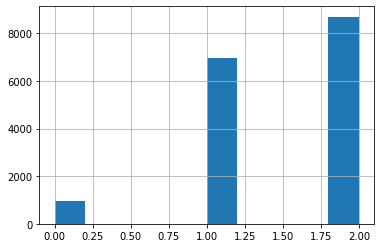

In [14]:
test_set.label.hist()

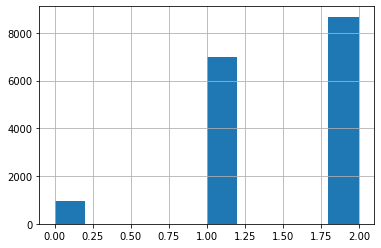

In [13]:
val_set.label.hist()

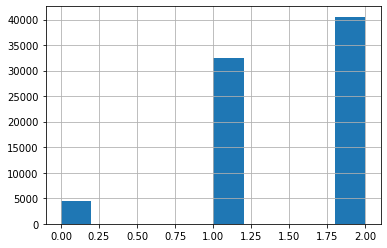

In [15]:
train_set.label.hist()

In [19]:
print('all = ', data_cleaned.shape[0])
print('train = ', train_set.shape[0])
print('val = ', val_set.shape[0])
print('test = ', test_set.shape[0])
print('train + val + test = ', train_set.shape[0]+val_set.shape[0]+test_set.shape[0])

all =  110748
train =  77522
val =  16613
test =  16613
train + val + test =  110748


In [7]:
def split_data(data_cleaned=None, train_p=0.7, val_p=0.15, test_p=0.15, random_state=42):
    """This function gets the cleaned dataset and splits it into train, validation and test set.

    In a pipeline you can specify the input with the variable "data_cleaned". If nothing is specified, it will get the data from our github repository. 

    Also you can specify proportions for the split with "train" (default set to 0.7), "val" (default set to 0.15), and "test" (default set to 0.15).
    """
    # importing packages
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit

    # checking if val_p + test_p + train_p = 1 and throwing an error otherwise
    x = val_p + test_p + train_p
    if x != 1:
        raise Exception('train_p + val_p + test_p should sum up to 1, however they sum up to: {}'.format(x))

    # setting the github url from where to get the data
    url_data_cleaned = 'https://raw.githubusercontent.com/MaximilianKupi/nlp-project/master/coding/code/exchange_base/data.csv'

    # reading the data in case it is not here already (since it will later all be applied in one pipeline)
    if data_cleaned is None:
        data_cleaned = pd.read_csv(url_data_cleaned)
        print('INFO: Reading data_cleaned anew from github since no input was provided')

    # instatiating the class for the shuffle split of training and test/validation set
    split = StratifiedShuffleSplit(n_splits=10, test_size = test_p, random_state = random_state)

    for train_val_index, test_index in split.split(data_cleaned, data_cleaned['label']):
        train_val_set = data_cleaned.loc[train_val_index]
        test_set = data_cleaned.loc[test_index]

    # instantiating the class for the shufle split of test and validation set
    # getting the new proportion for the validation set if train + val = 1
    val_p_sub = val_p * 20/17

    split2 = StratifiedShuffleSplit(n_splits=10, test_size = val_p_sub, random_state = random_state)

    for train_index, val_index in split2.split(train_val_set, train_val_set['label']):
        train_set = data_cleaned.loc[train_index]
        val_set = data_cleaned.loc[val_index]
    
    print(train_set.type())
    print(val_set.type())
    print(test_set.type())
    
    # changing to pandas dataframe
    ret = {
		'train_set': train_set,
		'test_set': test_set,
        'val_set': val_set,
	}

    return ret


In [8]:
split_data()

INFO: Reading data_cleaned anew from github since no input was provided


AttributeError: 'DataFrame' object has no attribute 'type'

In [9]:
import M1_3_splitting_datasets as m1_3 

train_set, val_set, test_set = m1_3.split_data()

ModuleNotFoundError: No module named 'M1_3_splitting_datasets'

In [12]:
import pandas as pd
train_set= pd.read_csv("/Users/mxm/Google Drive/Masterstudium/Inhalte/4th Semester/NLP/nlp-project/coding/code/exchange_base/train_set.csv")
val_set= pd.read_csv("/Users/mxm/Google Drive/Masterstudium/Inhalte/4th Semester/NLP/nlp-project/coding/code/exchange_base/val_set.csv")
test_set= pd.read_csv("/Users/mxm/Google Drive/Masterstudium/Inhalte/4th Semester/NLP/nlp-project/coding/code/exchange_base/test_set.csv")
data_cleaned = pd.read_csv('https://raw.githubusercontent.com/MaximilianKupi/nlp-project/master/coding/code/exchange_base/data.csv')
print('all = ', data_cleaned.shape[0])
print('train = ', train_set.shape[0])
print('val = ', val_set.shape[0])
print('test = ', test_set.shape[0])
print('train + val + test = ', train_set.shape[0]+val_set.shape[0]+test_set.shape[0])

all =  110748
train =  77522
val =  16613
test =  16613
train + val + test =  110748


In [2]:
import re
string.punctuation

NameError: name 'string' is not defined

In [ ]:
'!"#$%&()*+, -./:;<=>?@[\]^_{|}~'

In [1]:
# Loading packages
#import csv
#import sys
#import nltk
import pandas as pd
import torch
import spacy
#import dframcy
import pandarallel

def apply_dict(data = None):
    """This function matches the terms in the Hatebase.org dictionary with the tweets in our dataset.
    First, both datasets are lemmatized, then the function counts the number of hatebase.org terms appearing in each tweet and adds the count as well as the average offensiveness (as defined by hatebase.org methodology). These two outputs are then added to the original dataset and further transformed into a tensor for further analysis.
    The input dataframe (tweets) can be specified with the variable "data". If nothing is specified, the function will get the data from our GitHub repository."""

    # Loading the data

    # loading Hatebase dictionary
    hatebase_url = "https://raw.githubusercontent.com/MaximilianKupi/nlp-project/master/coding/data/dictionary/hatebase/full_dictionary.csv"
    hatebase_dic = pd.read_csv(hatebase_url, index_col = 'vocabulary_id')

    # github url for loading the tweets in case they are not provided
    data_url = "https://raw.githubusercontent.com/MaximilianKupi/nlp-project/master/coding/code/exchange_base/data.csv"

    # reading the data in case it is not here already (since it will later all be applied in one pipeline)
    if data is None:
        data = pd.read_csv(data_url, index_col = 'id')
        print('INFO: Reading data anew from GitHub since no input was provided')

    # Lemmatizing both the dictionary and the tweets
    
    # loading the spacy model
    nlp = spacy.load('en_core_web_sm')
    # switching off irrelevant spacy functions
    nlp.disable_pipes('tagger', 'ner')

    # lemmatizing the dictionary
    lemma = []
    for term in nlp.pipe(hatebase_dic['term'].astype('unicode').values, batch_size=50, n_threads=3):
        if term.is_parsed:
            lemma.append([n.lemma_ for n in term])
        else:
            lemma.append(None)

    # storing the lemmas in a new column 
    hatebase_dic['term_lemma'] = lemma

    #making lemmas lowercase
    hatebase_dic['term_lemma'] = hatebase_dic['term_lemma'].map(lambda lemmas: [x.lower() for x in lemmas])
        
    #joining list of lemmas into one string again, so it becomes matchable by the searchfunction
    hatebase_dic['term_lemma'] = hatebase_dic['term_lemma'].map(lambda lemmas: " ".join(lemmas))


    # lemmatizing the tweets
    lemma = []

    for tweet in nlp.pipe(data['tweet'].astype('unicode').values, batch_size=80, n_threads=5):
        if tweet.is_parsed:
            lemma.append([n.lemma_ for n in tweet])
        else:
            lemma.append(None)

    # storing the lemmas in a new column 
    data['tweet_lemma'] = lemma

    #making lemmas lowercase
    data['tweet_lemma'] = data['tweet_lemma'].map(lambda lemmas: [x.lower() for x in lemmas])
        
    #joining list of lemmas into one string agein, so it becomes matchable by the searchfunction
    data['tweet_lemma'] = data['tweet_lemma'].map(lambda lemmas: " ".join(lemmas))

    # Searching for HateBase words in tweets

    pandarallel.initialize() 

    # defining the search function
    def hatesearch(row):
        frequency = 0
        hatefulness = 0
        for term_lemma in hatebase_dic['term_lemma']:
            if term_lemma in row['tweet_lemma']:
                frequency += 1
                hatefulness = hatebase_dic[hatebase_dic['term_lemma'] == term_lemma].average_offensiveness
        row['Hatefreq'] = frequency
        row['Hatefulness'] = hatefulness
        return row


    # running the search function
    data = data.parallel_apply(hatesearch, axis = 1)

    # Building a tensor out of the additional columns

    HateFrequency = torch.tensor(data['Hatefreq'])

    HateIntensity = torch.tensor(data['Hatefulness'])

    return HateFrequency, HateIntensity

ModuleNotFoundError: No module named 'torch'

In [5]:

# Running the function

HateFrequency, HateIntensity = apply_dict()

# output_file_name = "exchange_base/hatefreq.pt"
# 2. use exchange_base files
path = "exchange_base/"

# input_file = path + stage + "_set.csv"
output_file_name_hatefreq = path +  "hatefreq.pt"
output_file_name_hateint = path + "hateint.pt"

### Saving the data
# Saving the vectorized tweets tensor
torch.save(HateFrequency, output_file_name_hatefreq)
# Saving the label tensor
torch.save(HateIntensity, output_file_name_hateint)


INFO: Reading data anew from GitHub since no input was provided


ValueError: spacy.syntax.nn_parser.Parser size changed, may indicate binary incompatibility. Expected 72 from C header, got 64 from PyObject